In [ ]:
import os
from pathlib import Path


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import tifffile as tiff

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision                # High-level computer vision utilities and pretrained models
from torchvision import transforms, models                   # Transformations for image preprocessing and model zoo
from pytorch_msssim import ssim

from sklearn.decomposition import PCA
from matplotlib.colors import BoundaryNorm

import umap.umap_ as umap

#### !!! copy in /train: Crontrol1 Mutant1 Mutant2
#### !!! copy in /test:  Crontrol2 Mutant3 Mutant4


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # For more reproducibility (slows down a bit)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Seed set to {seed}")

In [ ]:
# Path to data / train
ROOT_train = Path.home() / "Documents/project_004/data/data_small_zfish/train"

# Load all tiff stacks
tiff_paths_train = sorted(ROOT_train.glob("*.tif"))
print("Found stacks:", len(tiff_paths_train))

stacks_train = []
embryo_ids_train = []
lengths_train = []

for p in tiff_paths_train:
    arr_train = tiff.imread(str(p)).astype(np.float32)  # shape: (T_i, H, W)
    stacks_train.append(arr_train)
    embryo_ids_train.append(p.stem)
    lengths_train.append(arr_train.shape[0])

total_frames_train= sum(lengths_train)
print("Total frames across all stacks:", total_frames_train)

# Metadata per frame (embryo_id, frame index)
frame_embryo_train = np.concatenate([[eid] * L for eid, L in zip(embryo_ids_train, lengths_train)])
frame_idx_train = np.concatenate([np.arange(L) for L in lengths_train])

dfmeta_train  = pd.DataFrame({
    "embryo_id": frame_embryo_train,
    "frame_idx": frame_idx_train
})
dfmeta_train.head(), dfmeta_train .shape


Found stacks: 3
Total frames across all stacks: 1350


(  embryo_id  frame_idx
 0  Control1          0
 1  Control1          1
 2  Control1          2
 3  Control1          3
 4  Control1          4,
 (1350, 2))

In [ ]:
# Path to data
ROOT_test = Path.home() / "Documents/project_004/data/data_small_zfish/test"

# Load all tiff stacks
tiff_paths_test = sorted(ROOT_test.glob("*.tif"))
print("Found stacks:", len(tiff_paths_test))

stacks_test = []
embryo_ids_test = []
lengths_test = []

for p in tiff_paths_test:
    arr_test = tiff.imread(str(p)).astype(np.float32)  # shape: (T_i, H, W)
    stacks_test.append(arr_test)
    embryo_ids_test.append(p.stem)
    lengths_test.append(arr_test.shape[0])

total_frames_test = sum(lengths_test)
print("Total frames across all stacks:", total_frames_test)

# Metadata per frame (embryo_id, frame index)
frame_embryo_test = np.concatenate([[eid] * L for eid, L in zip(embryo_ids_test, lengths_test)])
frame_idx_test = np.concatenate([np.arange(L) for L in lengths_test])

dfmeta_test  = pd.DataFrame({
    "embryo_id": frame_embryo_test,
    "frame_idx": frame_idx_test
})
dfmeta_test.head(), dfmeta_test.shape

Found stacks: 3
Total frames across all stacks: 1350


(  embryo_id  frame_idx
 0  Control2          0
 1  Control2          1
 2  Control2          2
 3  Control2          3
 4  Control2          4,
 (1350, 2))

In [ ]:
class AEDataset(Dataset):
    def __init__(self, stacks, noise_std=0.0, crop_size=None, transform=None):
        """
        stacks : list of np.ndarray, each with shape (T_i, H, W)
        noise_std : float, std of optional Gaussian noise. 0.0 = plain AE
        crop_size : tuple, (height, width) of random crop, or None for full frame
        """
        self.stacks = [s.astype(np.float32) for s in stacks]
        self.transform = transform

        # Build global index: (stack_idx, frame_idx)
        self.index = []
        for stack_idx, s in enumerate(self.stacks):
            T = s.shape[0]
            for t in range(T):
                self.index.append((stack_idx, t))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        stack_idx, t = self.index[idx]
        img = self.stacks[stack_idx][t]  # (H, W)

        # Normalize to [0, 1]
        img = img.astype(np.float32)
        img -= img.min()
        if img.max() > 0:
            img = img / img.max()

        # Add channel dimension -> (1, H, W)
        if img.ndim == 2:
            img = img[None, :, :]  # (1, H, W)

        image = torch.from_numpy(img)

        #transform
        if self.transform:
                image = self.transform(image)

        return image.float(), image.float()

In [ ]:
# Data augmentation + preprocessing for training

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),              # Random horizontal flip: Increases symmetry: retinas are often symmetric
    transforms.RandomRotation(degrees=180),               # Random rotation: Simulates head tilt, camera rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  #Color Jitter simulates variation across devices
    #transforms.RandomAffine(degrees=10, translate=(0.05,0.005)),
    # No ToTensor here: AEDataset already returns a torch tensor
])

# For val/test we do not need augmentation
val_transform = None
test_transform = None

In [ ]:
set_seed(42)

Seed set to 42


In [ ]:
#Base dataset (no transform) to define indices
base_dataset = AEDataset(stacks=stacks_train, transform=None)
num_frames = len(base_dataset)
print("Total frames in base dataset:", num_frames)

Total frames in base dataset: 1350


In [ ]:
batch_size = 16


#Train/Val split indices (80/20 split)
train_size = int(0.8 * num_frames)
val_size = num_frames - train_size

indices = torch.randperm(num_frames).tolist()
train_indices = indices[:train_size]
val_indices   = indices[train_size:]


# Datasets with and without transform
# Train dataset with augmentation
train_dataset = AEDataset(stacks=stacks_train, transform=train_transform)

# Validation dataset without augmentation
val_dataset   = AEDataset(stacks=stacks_train, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))


#Test dataset and loader (no augmentation)
test_dataset = AEDataset(stacks=stacks_test, transform=test_transform)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Test dataset length (frames):", len(test_dataset))


Train batches: 68 Val batches: 17
Test dataset length (frames): 1350


In [ ]:
!!! Add plot of the data batch for traing and validations: Plot dataset batches

In [ ]:
class AutoEncoder_nosup(nn.Module):
    def __init__(self, latent_dim=256, input_size=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        # compute encoder output shape
        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_size, input_size)
            h = self.encoder(dummy)
        self.enc_out_shape = h.shape[1:]           # (C, H, W)
        enc_out_dim = h.numel()                    # C * H * W

        self.flatten = nn.Flatten()
        self.fc_latent = nn.Linear(enc_out_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, enc_out_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = self.flatten(h)
        z = self.fc_latent(h)
        return z

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, *self.enc_out_shape)
        x_hat = self.decoder(h)
        return x_hat

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 256

model1 = AutoEncoder_nosup(latent_dim=latent_dim).to(device)

optimizer = torch.optim.Adam(model1.parameters(), lr=1e-5)

#Loss Functions
criterion_mse = nn.MSELoss()

def ssim_loss(x,y):
    return 1-ssim(x,y,data_range=1.0)

def combined_loss(x_hat, x, alpha=0.1):
    mse=criterion_mse(x_hat, x)
    ssim_1=ssim_loss(x_hat, x)
    return alpha * mse + (1-alpha) * ssim_1


In [ ]:
def train_ae_nosup(model1, train_loader1, val_loader1, optimizer, device,
                   epochs=100, patience=5, save_path="best_ae.pth"):
    model1.to(device)
    history1 = {'train_loss': [], 'val_loss': []}

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        # TRAIN
        model1.train()
        train_loss = 0.0
        for noisy, clean in train_loader1:
            noisy = noisy.to(device)
            clean = clean.to(device)

            optimizer.zero_grad()
            output = model1(noisy)
            loss = ssim_loss(output, clean)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * noisy.size(0)

        train_loss /= len(train_loader1.dataset)

        # VALIDATION
        model1.eval()
        val_loss = 0.0
        with torch.no_grad():
            for noisy, clean in val_loader1:
                noisy = noisy.to(device)
                clean = clean.to(device)
                output = model1(noisy)
                loss = ssim_loss(output, clean)
                val_loss += loss.item() * noisy.size(0)

        val_loss /= len(val_loader1.dataset)

        history1['train_loss'].append(train_loss)
        history1['val_loss'].append(val_loss)

        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # EARLY STOPPING + SAVE BEST MODEL
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            # SAVE BEST WEIGHTS
            torch.save(model1.state_dict(), save_path)
            print(f"  → New best model saved to {save_path}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    return history1

In [ ]:
best_model_path = "best_ae_zfish.pth"
history1 = train_ae_nosup(model1, train_loader1, val_loader1, optimizer, device, epochs=200, patience=2,
                          save_path=best_model_path)

Epoch 001 | Train Loss: 0.893107 | Val Loss: 0.892657
  → New best model saved to best_ae_zfish.pth
Epoch 002 | Train Loss: 0.892680 | Val Loss: 0.892180
  → New best model saved to best_ae_zfish.pth
Epoch 003 | Train Loss: 0.892229 | Val Loss: 0.891754
  → New best model saved to best_ae_zfish.pth
Epoch 004 | Train Loss: 0.891860 | Val Loss: 0.891434
  → New best model saved to best_ae_zfish.pth
Epoch 005 | Train Loss: 0.891565 | Val Loss: 0.891184
  → New best model saved to best_ae_zfish.pth
Epoch 006 | Train Loss: 0.891352 | Val Loss: 0.890986
  → New best model saved to best_ae_zfish.pth
Epoch 007 | Train Loss: 0.891178 | Val Loss: 0.890830
  → New best model saved to best_ae_zfish.pth
Epoch 008 | Train Loss: 0.891049 | Val Loss: 0.890701
  → New best model saved to best_ae_zfish.pth
Epoch 009 | Train Loss: 0.890922 | Val Loss: 0.890588
  → New best model saved to best_ae_zfish.pth
Epoch 010 | Train Loss: 0.890804 | Val Loss: 0.890492
  → New best model saved to best_ae_zfish.pth


In [ ]:
#how to load best model
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#latent_dim = 48

#model1 = AutoEncoder_nosup(latent_dim=latent_dim).to(device)
#best_model_path = "best_ae_zfish.pth"

#state_dict = torch.load(best_model_path, map_location=device)
#model1.load_state_dict(state_dict)
#model1.eval()

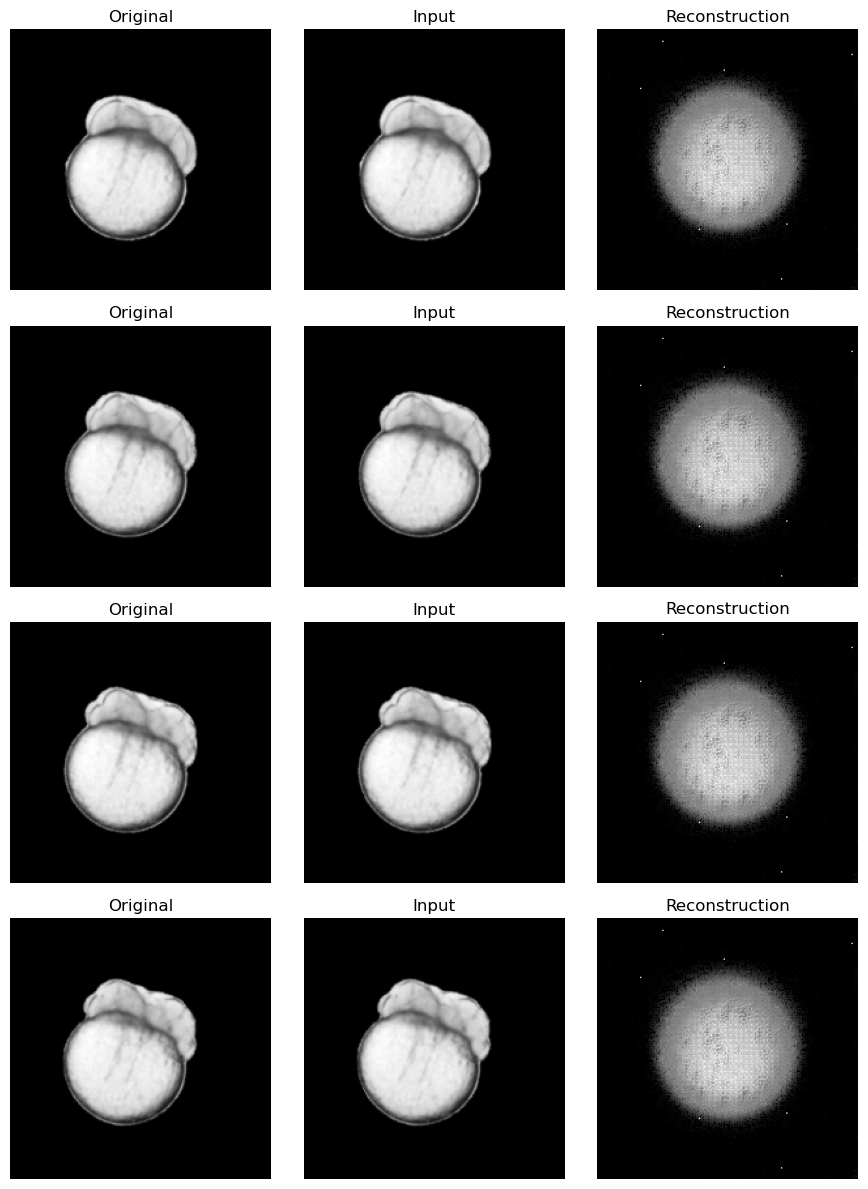

In [ ]:
model1.eval()
noisy_batch, clean_batch = next(iter(test_loader))
noisy_batch = noisy_batch.to(device)
with torch.no_grad():
    recon_batch = model1(noisy_batch)

noisy_batch = noisy_batch.cpu().numpy()
clean_batch = clean_batch.numpy()
recon_batch = recon_batch.cpu().numpy()

n_show = 4
plt.figure(figsize=(9, 3*n_show))
for i in range(n_show):
    # original
    plt.subplot(n_show, 3, 3*i + 1)
    plt.imshow(clean_batch[i, 0], cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # input
    plt.subplot(n_show, 3, 3*i + 2)
    plt.imshow(noisy_batch[i, 0], cmap="gray")
    plt.title("Input")
    plt.axis("off")

    # reconstruction
    plt.subplot(n_show, 3, 3*i + 3)
    plt.imshow(recon_batch[i, 0], cmap="gray")
    plt.title("Reconstruction")
    plt.axis("off")

plt.tight_layout()
plt.show()


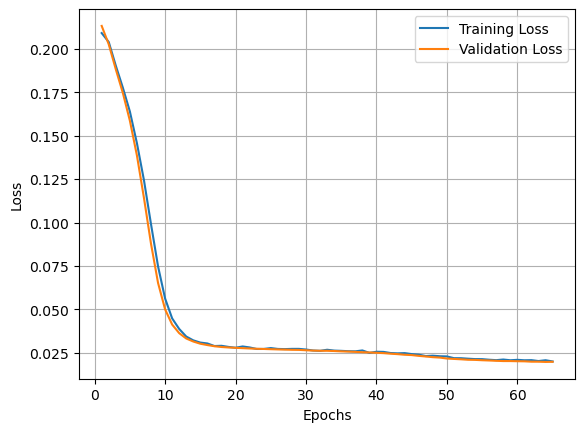

In [ ]:
train_losses = history1['train_loss']
val_losses   = history1['val_loss']

plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def extract_latent_ae(model1, dataset, device):
    model1.eval()
    latents = []

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    with torch.no_grad():
        for noisy, clean in loader:
            noisy = noisy.to(device)
            z = model1.encode(noisy)
            latents.append(z.cpu())

    Z = torch.cat(latents, dim=0)
    return Z

In [ ]:
# Clean dataset (no transform) for evaluation
eval_dataset_train = AEDataset(stacks=stacks_train, transform=None)

# Extract latent space
Z_ae = extract_latent_ae(model1, eval_dataset_train, device)
Z_ae_np = Z_ae.numpy()
print("Latent shape:", Z_ae_np.shape)   # (n_frames, latent_dim)

Latent shape: (1350, 36)


In [ ]:
Z_ae_np = Z_ae.numpy()
pca = PCA(n_components=2)
Z_pca = pca.fit_transform(Z_ae_np)

Z_pca.shape  # (2700, 2)


(1350, 2)

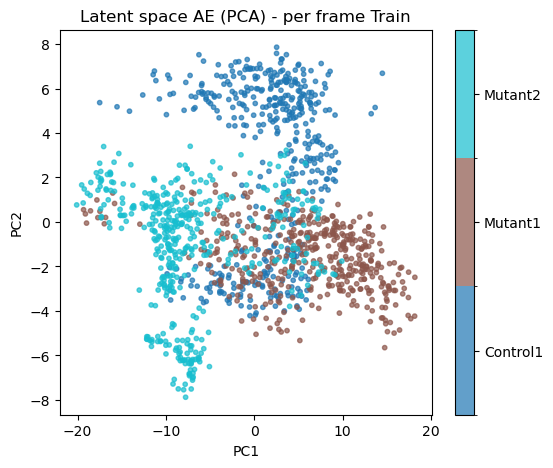

In [ ]:
embryo_labels = dfmeta_train["embryo_id"].values

# Unique embryo IDs
embryo_ids = np.unique(embryo_labels)          # array of 6 IDs
unique_embryos = {e: i for i, e in enumerate(embryo_ids)}
colors = [unique_embryos[e] for e in embryo_labels]

# discrete colormap with exactly 6 colors
cmap = plt.get_cmap("tab10", len(embryo_ids))
bounds = np.arange(-0.5, len(embryo_ids) + 0.5)
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(6, 5))
sc = plt.scatter(
    Z_pca[:, 0],
    Z_pca[:, 1],
    c=colors,
    s=10,
    alpha=0.7,
    cmap=cmap,
    norm=norm
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Latent space AE (PCA) - per frame Train")

cbar = plt.colorbar(sc, ticks=range(len(embryo_ids)))
cbar.ax.set_yticklabels(embryo_ids)  # show real embryo IDs

plt.show()


In [ ]:
# Latent space on TEST
eval_dataset_test = AEDataset(stacks=stacks_test, transform=None)
Z_test = extract_latent_ae(model1, eval_dataset_test, device)     # (N_test, latent_dim)
Z_test_np = Z_test.numpy()
print("Test latent shape:", Z_test_np.shape)

# Transform TEST with the SAME PCA
Z_test_pca = pca.transform(Z_test_np)             # (N_test, 2)
print("Test PCA shape:", Z_test_pca.shape)

Train latent shape: (1350, 36)
Train PCA shape: (1350, 2)
Test latent shape: (1350, 36)
Test PCA shape: (1350, 2)


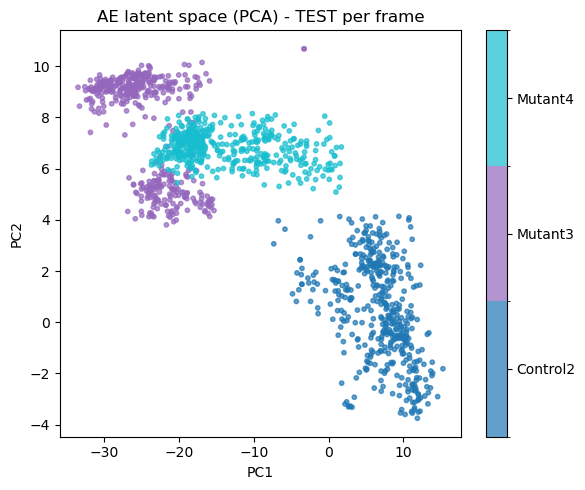

In [ ]:
embryo_labels_test = dfmeta_test["embryo_id"].values  # length = N_test
embryo_ids_test = np.unique(embryo_labels_test)
unique_embryos_test = {e: i for i, e in enumerate(embryo_ids_test)}
colors_test = [unique_embryos_test[e] for e in embryo_labels_test]

plt.figure(figsize=(6, 5))
sc = plt.scatter(
    Z_test_pca[:, 0],
    Z_test_pca[:, 1],
    c=colors,
    s=10,
    alpha=0.7,
    cmap=cmap,
    norm=norm
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("AE latent space (PCA) - TEST per frame")

cbar = plt.colorbar(sc, ticks=range(len(embryo_ids_test)))
cbar.ax.set_yticklabels(embryo_ids_test)
plt.tight_layout()
plt.show()


In [ ]:
## UMAP
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42,
)

Z_umap = reducer.fit_transform(Z_ae_np)      # shape: (n_frames, 2)
print("UMAP shape:", Z_umap.shape)

/home/pxbloe/anaconda3/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (1350, 2)


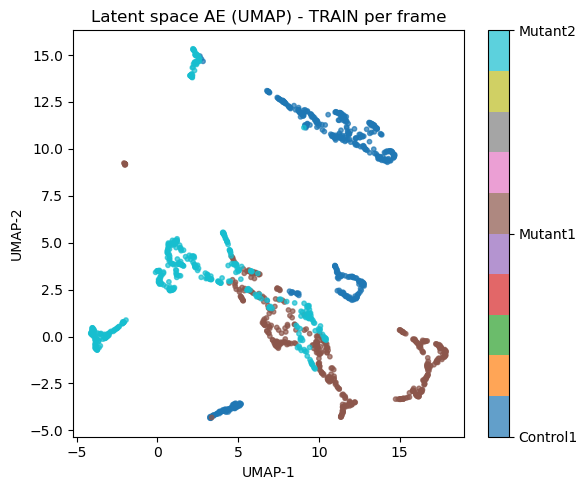

In [ ]:
embryo_labels = dfmeta_train["embryo_id"].values  # same length as Z_umap

# Unique embryo IDs
embryo_ids = np.unique(embryo_labels)
unique_embryos = {e: i for i, e in enumerate(embryo_ids)}
colors = [unique_embryos[e] for e in embryo_labels]

# Discrete colormap with exactly len(embryo_ids) colors
cmap = plt.get_cmap("tab10")
bounds = np.arange(len(embryo_ids) + 1) - 0.5
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(6, 5))
sc = plt.scatter(
    Z_umap[:, 0],
    Z_umap[:, 1],
    c=colors_test,
    s=10,
    alpha=0.7,
    cmap=cmap
)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("Latent space AE (UMAP) - TRAIN per frame")

cbar = plt.colorbar(sc, ticks=range(len(embryo_ids)))
cbar.ax.set_yticklabels(embryo_ids)  # show real embryo IDs

plt.tight_layout()
plt.show()

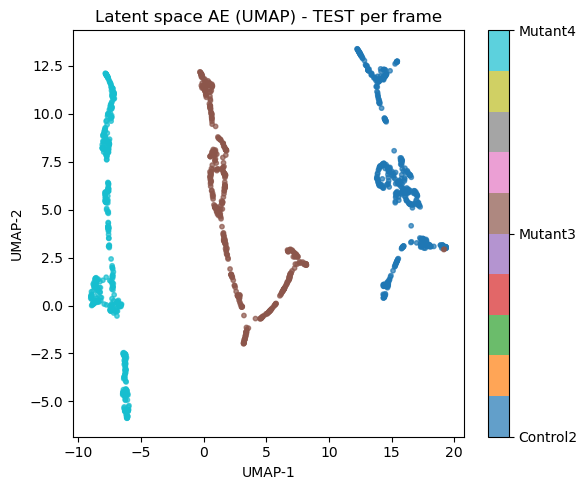

In [ ]:
#UMAP for testset
# Latent on test
eval_dataset_test = AEDataset(stacks=stacks_test, transform=None)
Z_ae_test = extract_latent_ae(model1, eval_dataset_test, device)
Z_ae_test_np = Z_ae_test.numpy()

Z_umap_test = reducer.fit_transform(Z_ae_test_np)

embryo_labels_test = dfmeta_test["embryo_id"].values
embryo_ids_test = np.unique(embryo_labels_test)
unique_embryos_test = {e: i for i, e in enumerate(embryo_ids_test)}
colors_test = [unique_embryos_test[e] for e in embryo_labels_test]

plt.figure(figsize=(6, 5))
sc = plt.scatter(
    Z_umap_test[:, 0],
    Z_umap_test[:, 1],
    c=colors_test,
    s=10,
    alpha=0.7,
    cmap=cmap
)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("Latent space AE (UMAP) - TEST per frame")

cbar = plt.colorbar(sc, ticks=range(len(embryo_ids_test)))
cbar.ax.set_yticklabels(embryo_ids_test)
plt.tight_layout()
plt.show()


In [ ]:
def eval_recon_loss(model, loader, device):
    model.eval()
    total_loss = 0.0
    criterion = nn.MSELoss(reduction="mean")

    with torch.no_grad():
        for noisy, clean in loader:
            noisy = noisy.to(device)
            clean = clean.to(device)
            recon = model(noisy)
            loss = criterion(recon, clean)
            total_loss += loss.item() * noisy.size(0)

    return total_loss / len(loader.dataset)

train_recon = eval_recon_loss(model1, train_loader1, device)
val_recon   = eval_recon_loss(model1, val_loader1, device)
test_recon  = eval_recon_loss(model1, test_loader,  device)

print("Recon MSE | train:", train_recon)
print("Recon MSE | val  :", val_recon)
print("Recon MSE | test :", test_recon)


Recon MSE | train: 0.02062876294884417
Recon MSE | val  : 0.019887807592749596
Recon MSE | test : 0.027640097833893918
